<a href="https://colab.research.google.com/github/kdh4672/economy_ai/blob/main/olive_oil_reference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# upgrade fastai to the most recent version (v. 2.5.3)

%%capture
!pip install fastai --upgrade

In [3]:
import fastai
print(fastai.__version__)

from fastai.vision.all import *
#from fastai.text.all import *
#from fastai.collab import *
#from fastai.tabular.all import * 

from matplotlib.pyplot import imshow

2.5.6


In [4]:
%%capture
!pip install -Uqq fastbook

In [5]:
from fastbook import *

AttributeError: ignored

In [ ]:
from google.colab import files

In [ ]:
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)


# 2. Download file

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
!unzip 'OliveOil.zip'

Archive:  OliveOil.zip
  inflating: OliveOil.txt            
  inflating: OliveOil_TEST.arff      
  inflating: OliveOil_TEST.txt       
  inflating: OliveOil_TRAIN.arff     
  inflating: OliveOil_TRAIN.txt      
  inflating: OliveOil_TEST.ts        
  inflating: OliveOil_TRAIN.ts       


In [ ]:
# file_path = '/content/'
# file_name1 = 'OliveOil_TRAIN.txt'
# file_name2 = 'OliveOil_TEST.txt'



*   항목 추가
*   항목 추가



In [7]:
from pathlib import Path

In [8]:
train_csv = Path('OliveOil_TRAIN.txt')
valid_csv = Path('OliveOil_TEST.txt')

# 3. Load raw files as Pandas dataframes

In [9]:
# df1 = pd.read_csv(file_path + file_name1,
#                   sep = '  ', # 스페이스 두번임
#                   header = None)
# df2 = pd.read_csv(file_path + file_name2,
#                   sep = '  ',
#                   header = None)
train_df = pd.read_csv(train_csv,
                  delim_whitespace = True,
                  header = None)
valid_df = pd.read_csv(valid_csv,
                  delim_whitespace = True,
                  header = None)

In [10]:
df = pd.concat([train_df, valid_df])
df.shape

(60, 571)

# 4. Create label arrays (ground truth data) (정답값 추출)

In [11]:
y_train = train_df[[0]].to_numpy(dtype=int).reshape(-1) # 첫번째 컬럼은 원산지에 대한 정답 label 값
y_train # np.array

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4])

In [12]:
y_valid = valid_df[[0]].to_numpy(dtype=int).reshape(-1) # 마찬가지
y_valid # np.array

array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4])

# 5. Remove labels from df and scale feature values (방금 추출한 0번째 정답 컬럼 제외하고 노말라이즈)

In [13]:
# minmax scale

from sklearn.preprocessing import MinMaxScaler

# load scaler
scaler = MinMaxScaler()

# fit
scaler.fit(train_df.iloc[:, 1:]) # fit on entire(x) only train set to get common min and max values
# : 전체 로우 다 쓸거다 , 1: 첫번째 컬럼부터 쓸거다
# 0 ~ 1 사이로 scaling

# transform dataframes (take out first column which is label)
# X_train = pd.DataFrame(scaler.transform(train_df.iloc[:, 1:]), dtype='float32')
X_train = pd.DataFrame(scaler.fit_transform(train_df.iloc[:,1:]), dtype='float32')
X_valid = pd.DataFrame(scaler.transform(valid_df.iloc[:, 1:]), dtype='float32')

In [14]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,560,561,562,563,564,565,566,567,568,569
0,0.358067,0.355823,0.378694,0.388408,0.386555,0.406783,0.413601,0.389623,0.383649,0.380071,...,0.590959,0.579164,0.597925,0.613935,0.624188,0.641020,0.621194,0.590047,0.583302,0.608917
1,0.232015,0.259692,0.297728,0.286401,0.245094,0.260113,0.279321,0.299162,0.313247,0.294755,...,0.603417,0.616723,0.626186,0.620320,0.608032,0.606230,0.613048,0.610499,0.611548,0.628273
2,0.338497,0.358436,0.384239,0.410423,0.425656,0.422747,0.423233,0.433956,0.440583,0.424907,...,0.592370,0.604973,0.610685,0.601874,0.601660,0.591834,0.594359,0.596360,0.573529,0.583857
3,0.000000,0.000000,0.000000,0.000000,0.018897,0.043673,0.041631,0.043673,0.062207,0.062029,...,0.980236,0.954140,0.939835,0.947723,0.961166,0.957940,0.958132,0.953223,0.927060,0.931542
4,0.031101,0.029038,0.053080,0.037731,0.032142,0.040612,0.037860,0.019781,0.001610,0.004576,...,0.668324,0.670538,0.666428,0.664599,0.660936,0.647601,0.640008,0.656069,0.665213,0.669626
5,0.707879,0.692482,0.694363,0.723894,0.734589,0.758041,0.795415,0.816237,0.858001,0.843507,...,0.345624,0.330772,0.342080,0.338452,0.336147,0.363915,0.369803,0.362641,0.351003,0.345727
6,0.230823,0.246406,0.273084,0.297714,0.307803,0.310240,0.343075,0.349006,0.329266,0.309948,...,0.634284,0.642676,0.640213,0.650055,0.658441,0.662143,0.672754,0.665978,0.639203,0.625203
7,0.275224,0.301295,0.320634,0.329467,0.332224,0.336911,0.360004,0.383693,0.394105,0.387285,...,0.678963,0.694650,0.711854,0.689376,0.693342,0.717238,0.701357,0.696479,0.694205,0.669814
8,0.820196,0.831717,0.826250,0.852073,0.865667,0.856854,0.877764,0.898926,0.908854,0.926100,...,0.346481,0.372982,0.373312,0.353955,0.337775,0.363402,0.377688,0.357490,0.356581,0.345432
9,0.063954,0.064540,0.079280,0.070986,0.087582,0.100389,0.089338,0.072187,0.049689,0.055630,...,0.740894,0.740341,0.732268,0.721131,0.743843,0.758145,0.752654,0.750738,0.750494,0.732776


In [15]:
X_valid

,0,1,2,3,4,5,6,7,8,9,...,560,561,562,563,564,565,566,567,568,569
0,0.025957,0.047225,0.071693,0.071776,0.086236,0.112975,0.123859,0.135655,0.152393,0.145751,...,1.070276,1.054162,1.048691,1.062389,1.081129,1.084807,1.080335,1.069728,1.041415,1.041397
1,0.121130,0.118064,0.132929,0.146101,0.160013,0.167099,0.145948,0.141936,0.158963,0.160363,...,0.882326,0.879471,0.877815,0.866790,0.873486,0.899407,0.896552,0.881474,0.863353,0.855391
2,0.144841,0.168724,0.193126,0.181824,0.187720,0.207487,0.193272,0.195312,0.235390,0.242722,...,0.701949,0.702381,0.704769,0.717084,0.736340,0.729476,0.717472,0.709077,0.698572,0.711788
3,0.293097,0.321163,0.342864,0.345324,0.359889,0.360129,0.358722,0.365699,0.384765,0.385727,...,0.700497,0.697657,0.703598,0.698526,0.704688,0.711063,0.703314,0.698158,0.697217,0.701740
4,0.202312,0.211632,0.228700,0.248338,0.284672,0.303355,0.311533,0.315430,0.301954,0.304648,...,0.758245,0.763126,0.772844,0.764434,0.763689,0.779839,0.784323,0.771429,0.750487,0.762859
5,0.125623,0.137767,0.153150,0.160811,0.171675,0.175180,0.165975,0.152930,0.164064,0.167709,...,0.775410,0.783794,0.791647,0.783758,0.807077,0.821389,0.804233,0.803981,0.788418,0.771783
6,0.147506,0.196539,0.237768,0.245304,0.247607,0.230357,0.215848,0.249456,0.256320,0.240208,...,0.760305,0.752004,0.774731,0.781758,0.784796,0.790694,0.783895,0.779072,0.782427,0.782526
7,0.364651,0.369661,0.385961,0.399227,0.399354,0.426923,0.439669,0.423776,0.424869,0.436962,...,0.518932,0.525160,0.508909,0.506259,0.507242,0.505777,0.517791,0.525237,0.526673,0.507521
8,0.360378,0.355049,0.341162,0.366535,0.379881,0.389779,0.424798,0.448745,0.447313,0.439285,...,0.656419,0.661982,0.662342,0.652029,0.643693,0.635553,0.627335,0.636916,0.651043,0.645945
9,0.012480,0.033581,0.046320,0.014050,0.009447,0.027254,-0.003926,-0.023854,-0.003670,0.013563,...,0.661116,0.656264,0.663515,0.665428,0.669357,0.682645,0.675964,0.666092,0.647678,0.643420


# 6. Plot some data

In [16]:
import matplotlib.pyplot as plt

In [17]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,561,562,563,564,565,566,567,568,569,570
0,1.0,-0.611375,-0.610586,-0.606557,-0.601132,-0.594315,-0.585762,-0.577419,-0.570175,-0.563285,...,-0.979553,-0.980385,-0.980328,-0.980220,-0.980691,-0.981337,-0.982336,-0.983213,-0.983672,-0.983120
1,1.0,-0.615392,-0.613729,-0.609228,-0.604315,-0.598768,-0.590507,-0.581617,-0.572926,-0.565374,...,-0.979210,-0.979335,-0.979523,-0.980038,-0.981146,-0.982332,-0.982570,-0.982630,-0.982850,-0.982549
2,1.0,-0.611999,-0.610500,-0.606374,-0.600445,-0.593084,-0.585245,-0.577118,-0.568827,-0.561596,...,-0.979514,-0.979663,-0.979964,-0.980563,-0.981326,-0.982744,-0.983107,-0.983033,-0.983956,-0.983858
3,1.0,-0.622784,-0.622222,-0.619049,-0.613251,-0.605889,-0.597508,-0.589047,-0.580697,-0.572822,...,-0.968819,-0.969902,-0.970586,-0.970718,-0.971197,-0.972268,-0.972654,-0.972861,-0.973671,-0.973614
4,1.0,-0.621793,-0.621272,-0.617298,-0.612074,-0.605472,-0.597607,-0.589165,-0.581424,-0.574620,...,-0.977420,-0.977831,-0.978376,-0.978778,-0.979656,-0.981148,-0.981796,-0.981331,-0.981289,-0.981331
5,2.0,-0.600229,-0.599577,-0.596144,-0.590664,-0.583358,-0.574398,-0.565483,-0.557200,-0.549211,...,-0.986319,-0.987329,-0.987618,-0.988062,-0.988807,-0.989265,-0.989560,-0.989695,-0.990430,-0.990874
6,2.0,-0.615430,-0.614164,-0.610041,-0.603962,-0.596794,-0.588885,-0.579624,-0.571410,-0.564899,...,-0.978359,-0.978609,-0.979123,-0.979192,-0.979726,-0.980732,-0.980855,-0.981049,-0.982046,-0.982640
7,2.0,-0.614015,-0.612369,-0.608472,-0.602971,-0.596025,-0.588022,-0.579095,-0.570355,-0.562975,...,-0.977127,-0.977156,-0.977082,-0.978072,-0.978743,-0.979156,-0.980033,-0.980179,-0.980446,-0.981325
8,2.0,-0.596650,-0.595023,-0.591794,-0.586665,-0.579232,-0.571202,-0.562909,-0.554685,-0.547703,...,-0.986295,-0.986149,-0.986728,-0.987620,-0.988761,-0.989280,-0.989334,-0.989841,-0.990268,-0.990883
9,2.0,-0.620747,-0.620111,-0.616434,-0.611036,-0.603726,-0.595674,-0.587556,-0.579830,-0.573194,...,-0.975419,-0.975879,-0.976500,-0.977168,-0.977320,-0.977985,-0.978558,-0.978633,-0.978808,-0.979470


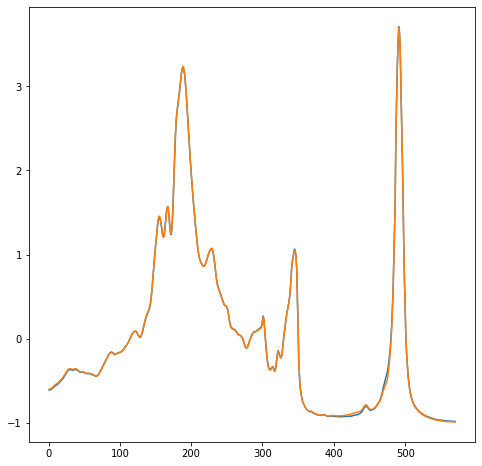

In [18]:
plt.figure(figsize=(8,8))
plt.plot(train_df.iloc[0,1:])
plt.plot(train_df.iloc[5,1:])
plt.show()
# raw data의 variation이 적다

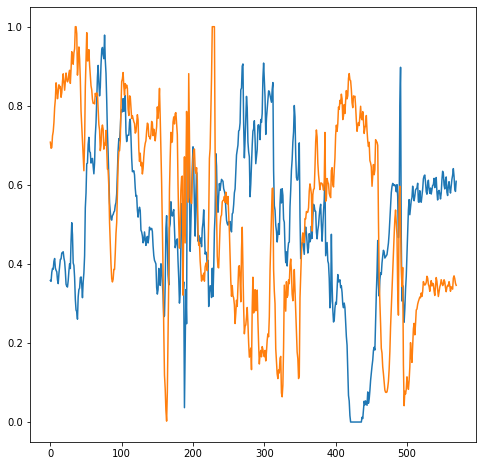

In [19]:
# plot some rows (class = 1)

plt.figure(figsize=(8, 8))
plt.plot(X_train.iloc[0])
plt.plot(X_train.iloc[5])
plt.show()

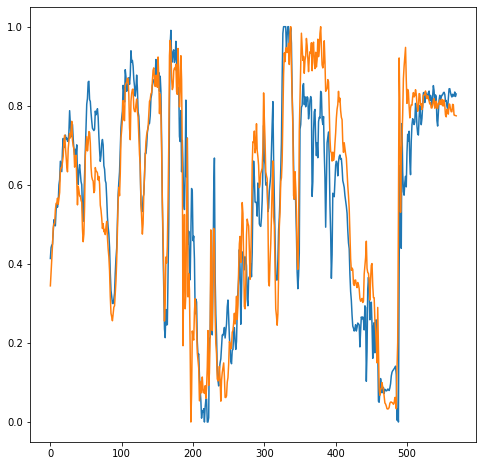

In [20]:
# plot some rows (class = 4)

plt.figure(figsize=(8, 8))
plt.plot(X_train.iloc[24])
plt.plot(X_train.iloc[25])
plt.show()

# 7. Convert time series to image (Gramian Angular Difference Field)

In [21]:
!pip install pyts

     |████████████████████████████████| 2.5 MB 5.3 MB/s 


In [22]:
from pyts.image import GramianAngularField

## 7.1 Transform train dataset to image using GADF

In [23]:
transformer = GramianAngularField(method='difference') 
X_train_GAF = transformer.fit_transform(X_train)
# X_train_GAF = transformer.transform(X_train)도 ok
X_train_GAF.shape

(30, 570, 570)

In [30]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,560,561,562,563,564,565,566,567,568,569
0,0.358067,0.355823,0.378694,0.388408,0.386555,0.406783,0.413601,0.389623,0.383649,0.380071,...,0.590959,0.579164,0.597925,0.613935,0.624188,0.641020,0.621194,0.590047,0.583302,0.608917
1,0.232015,0.259692,0.297728,0.286401,0.245094,0.260113,0.279321,0.299162,0.313247,0.294755,...,0.603417,0.616723,0.626186,0.620320,0.608032,0.606230,0.613048,0.610499,0.611548,0.628273
2,0.338497,0.358436,0.384239,0.410423,0.425656,0.422747,0.423233,0.433956,0.440583,0.424907,...,0.592370,0.604973,0.610685,0.601874,0.601660,0.591834,0.594359,0.596360,0.573529,0.583857
3,0.000000,0.000000,0.000000,0.000000,0.018897,0.043673,0.041631,0.043673,0.062207,0.062029,...,0.980236,0.954140,0.939835,0.947723,0.961166,0.957940,0.958132,0.953223,0.927060,0.931542
4,0.031101,0.029038,0.053080,0.037731,0.032142,0.040612,0.037860,0.019781,0.001610,0.004576,...,0.668324,0.670538,0.666428,0.664599,0.660936,0.647601,0.640008,0.656069,0.665213,0.669626
5,0.707879,0.692482,0.694363,0.723894,0.734589,0.758041,0.795415,0.816237,0.858001,0.843507,...,0.345624,0.330772,0.342080,0.338452,0.336147,0.363915,0.369803,0.362641,0.351003,0.345727
6,0.230823,0.246406,0.273084,0.297714,0.307803,0.310240,0.343075,0.349006,0.329266,0.309948,...,0.634284,0.642676,0.640213,0.650055,0.658441,0.662143,0.672754,0.665978,0.639203,0.625203
7,0.275224,0.301295,0.320634,0.329467,0.332224,0.336911,0.360004,0.383693,0.394105,0.387285,...,0.678963,0.694650,0.711854,0.689376,0.693342,0.717238,0.701357,0.696479,0.694205,0.669814
8,0.820196,0.831717,0.826250,0.852073,0.865667,0.856854,0.877764,0.898926,0.908854,0.926100,...,0.346481,0.372982,0.373312,0.353955,0.337775,0.363402,0.377688,0.357490,0.356581,0.345432
9,0.063954,0.064540,0.079280,0.070986,0.087582,0.100389,0.089338,0.072187,0.049689,0.055630,...,0.740894,0.740341,0.732268,0.721131,0.743843,0.758145,0.752654,0.750738,0.750494,0.732776


In [ ]:
# check min, max values

np.min(X_train_GAF), np.max(X_train_GAF)

In [26]:
X_train_GAF[0]

array([[ 0.        , -0.00476378,  0.04348923, ...,  0.46074604,
         0.44821873,  0.4955014 ],
       [ 0.00476378,  0.        ,  0.04824802, ...,  0.46496882,
         0.4524721 ,  0.49963363],
       [-0.04348923, -0.04824802,  0.        , ...,  0.42171204,
         0.4089186 ,  0.45725755],
       ...,
       [-0.46074604, -0.46496882, -0.42171204, ...,  0.        ,
        -0.01406343,  0.03956606],
       [-0.44821873, -0.4524721 , -0.4089186 , ...,  0.01406343,
         0.        ,  0.05361457],
       [-0.4955014 , -0.49963363, -0.45725755, ..., -0.03956606,
        -0.05361457,  0.        ]])

In [27]:
# Normalise numbers with range (0,255)

X_train_GAF_L = (((X_train_GAF + 1) / 2)*255).astype(int)

In [28]:
# check min, max values

np.min(X_train_GAF_L), np.max(X_train_GAF_L)

(0, 254)

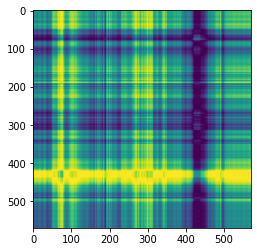

In [29]:
# plot first row (original array)

imshow(X_train_GAF[0])

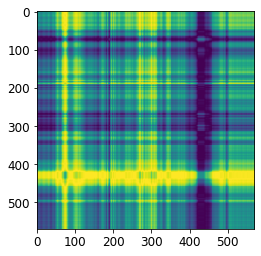

In [ ]:
# plot first row (rescaled array)

imshow(X_train_GAF_L[0])

## 7.2 Transform validation dataset to image using GADF

In [ ]:
X_valid_GAF = transformer.transform(X_valid)
X_valid_GAF.shape

(30, 570, 570)

In [ ]:
# check min, max values

np.min(X_valid_GAF), np.max(X_valid_GAF)

(-0.9999999999996503, 0.9999999999996503)

In [ ]:
X_valid_GAF[0]

array([[ 0.        ,  0.07867899,  0.16676287, ...,  0.43603297,  0.58950942,  0.59916184],
       [-0.07867899,  0.        ,  0.08866865, ...,  0.50548691,  0.6512358 ,  0.66029704],
       [-0.16676287, -0.08866865,  0.        , ...,  0.58000224,  0.71595916,  0.72428681],
       ...,
       [-0.43603297, -0.50548691, -0.58000224, ...,  0.        , -0.17830697, -0.19010395],
       [-0.58950942, -0.6512358 , -0.71595916, ...,  0.17830697,  0.        , -0.01200216],
       [-0.59916184, -0.66029704, -0.72428681, ...,  0.19010395,  0.01200216,  0.        ]])

In [ ]:
# Normalise numbers with range (0,255)

X_valid_GAF_L = (((X_valid_GAF + 1) / 2)*255).astype(int)

In [ ]:
# check min, max values

np.min(X_valid_GAF_L), np.max(X_valid_GAF_L)

(0, 254)

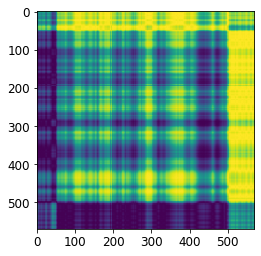

In [ ]:
# plot first row (original array)

imshow(X_valid_GAF[0])

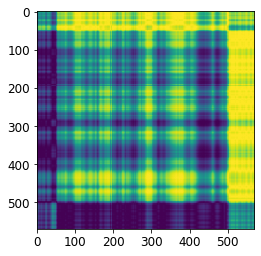

In [ ]:
# plot first row (rescaled array)

imshow(X_valid_GAF_L[0])

# 8. Save images under class name subfolders

In [ ]:
from os.path import join

In [ ]:
root_folder = '/content/drive/MyDrive/2022_AI와빅데이터를활용한경제정보처리/4차시/gaf_images'

# save train set images (e.g., train/class_name/0.png)

for i in range(len(y_train)):
    
    # define file names
    image_file_name = str(i) + '.png'

    # define folder names
    class_folder_name = str(y_train[i])
    full_path = os.path.join(root_folder, 'train')
    full_path = os.path.join(full_path, class_folder_name)
    
    # make folders
    if not os.path.exists(full_path):
        os.makedirs(full_path)

    # save images
    image_file_name_with_full_path = os.path.join(full_path, image_file_name)
    plt.imsave(image_file_name_with_full_path, X_train_GAF_L[i])

In [ ]:
# save vaild set images (e.g., valid/class_name/0.png)

for i in range(len(y_valid)):
    
    # define file names
    image_file_name = str(i) + '.png'

    # define folder names
    class_folder_name = str(y_valid[i])
    full_path = os.path.join(root_folder, 'valid')
    full_path = os.path.join(full_path, class_folder_name)
    
    # make folders
    if not os.path.exists(full_path):
        os.makedirs(full_path)

    # save images
    image_file_name_with_full_path = os.path.join(full_path, image_file_name)
    plt.imsave(image_file_name_with_full_path, X_valid_GAF_L[i])

# 9. Prepare data for CNN

In [ ]:
# data block settings

my_random_seed = 42
my_batch_size = 8

In [ ]:
from fastai.vision.data import ImageDataLoaders

In [ ]:
data = ImageDataLoaders.from_folder(
    root_folder, train="train", valid='valid',
    seed=my_random_seed, bs=my_batch_size)

In [ ]:
len(data.train_ds), len(data.valid_ds)

(30, 30)

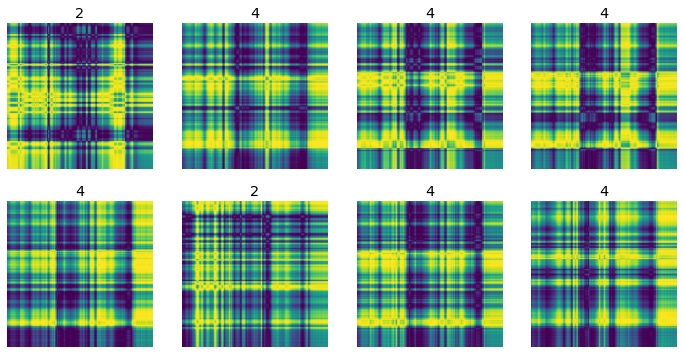

In [ ]:
# show image examples

data.show_batch(max_n=8, nrows=2)

# 10. Train CNN model

In [ ]:
learn = cnn_learner(data, resnet18, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time
0,2.829553,1.963130,0.233333,00:04


epoch,train_loss,valid_loss,accuracy,time
0,1.799559,2.198865,0.200000,00:03
1,1.860563,2.268685,0.133333,00:03
2,1.572974,1.851749,0.333333,00:03
3,1.244906,1.510809,0.400000,00:03
4,1.006934,1.217279,0.566667,00:03
5,0.878025,0.982716,0.700000,00:03
6,0.743857,0.855210,0.700000,00:03
7,0.689758,0.796379,0.733333,00:03
8,0.602808,0.753364,0.766667,00:03
9,0.535011,0.718563,0.766667,00:03


# 11 Confusion matrix and images with top losses

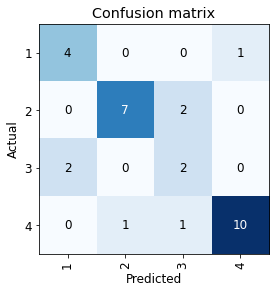

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

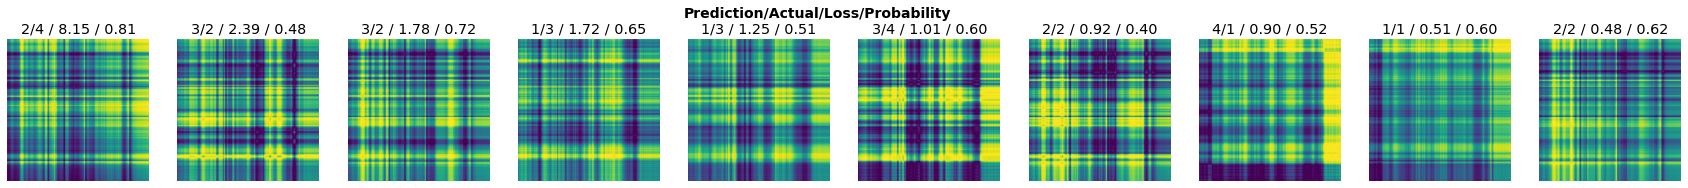

In [ ]:
plot_top_losses_fix(interp, 10, nrows=1)

# 1. Install and import libraries